In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import warnings
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/home/mach1ne/Downloads/TourismData_v3.csv')

In [3]:
data['Year'] = data['Year'].fillna(method='ffill')

In [4]:
import calendar

d = dict((v,k) for k,v in enumerate(calendar.month_name))

In [5]:
data.Month = data.Month.map(d)

In [6]:
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')

In [7]:
data = data.drop(['Year', 'Month'], axis=1)

In [8]:
# The last 8 points will be forecasted
y = data.iloc[:-8,:10]
y_ = y.values.flatten('F')


state_idx_list = pd.get_dummies(
        [i[0] for i in y.columns]
    ).values.argmax(1)

zone_idx_list = pd.get_dummies(
        [i[1] for i in y.columns]
    ).values.argmax(1)

region_idx_list = pd.get_dummies(
        [i[2] for i in y.columns]
    ).values.argmax(1)

purpose_idx_list = pd.get_dummies(
        [i[3:6] for i in y.columns]
    ).values.argmax(1)

n_series_idx_list = np.arange(y.shape[1])

state = np.unique(state_idx_list).shape[0]
zone = np.unique(zone_idx_list).shape[0]
region = np.unique(region_idx_list).shape[0]
purpose = np.unique(purpose_idx_list).shape[0]
n_series = np.unique(n_series_idx_list).shape[0]

n = y.shape[0]
s = y.shape[1]

X = np.concatenate((np.repeat(np.arange(n)[:,None], s, axis=1).T.reshape(-1,1), np.repeat(np.arange(s)[:,None], n, axis=0).T.reshape(-1,1)), axis=1)

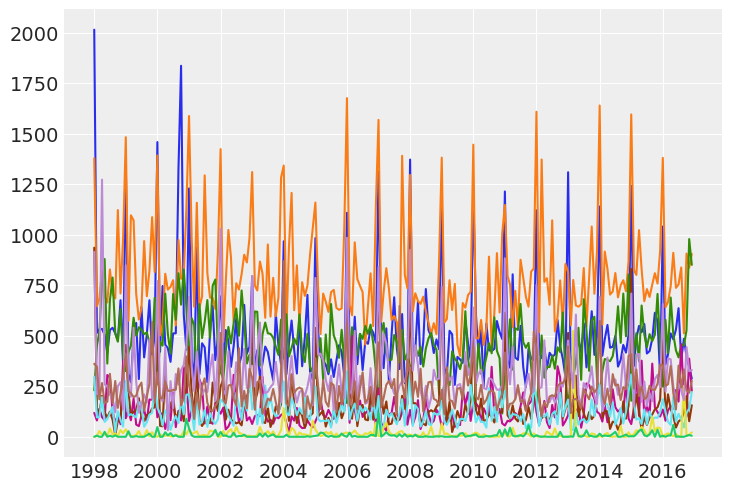

In [9]:
plt.plot(data.iloc[:,0:10]);

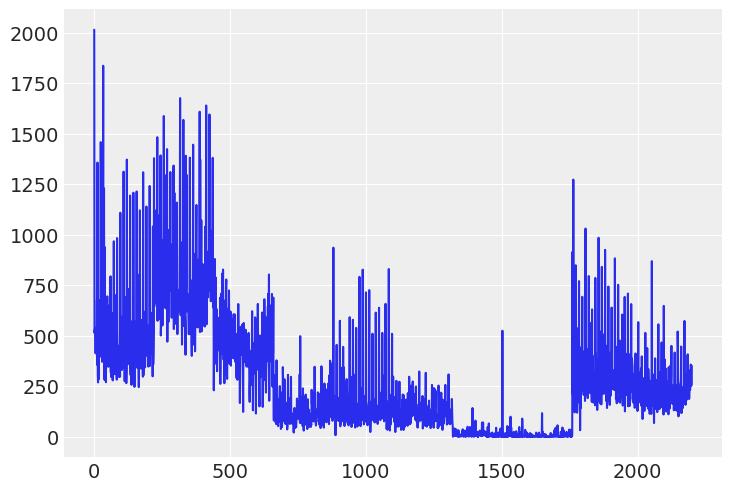

In [10]:
plt.plot(y_);

In [11]:
# Only allows to forecast one series at a time for now

class LinearMean(pm.gp.mean.Mean):

    def __init__(self, 
                 intercepts, 
                 #g1, 
                 g2, 
                 g3, 
                 g4,
                 slopes):
        self.b = slopes
        self.a0 = intercepts
        #self.a1 = g1
        self.a2 = g2
        self.a3 = g3
        self.a4 = g4

    def __call__(self, X):
        size_r = X.shape[0]
        series = int(X[0,1]) # series that we are forecasting

        X = theano.shared(X)

        if size_r == n*s:
            # fitting
            return tt.flatten(((X[:,0].reshape((s,-1)).T * self.b.reshape((1,-1))) 
                           + self.a0.reshape((1,-1))[:,n_series_idx_list] 
                           #+ self.a1.reshape((1,-1))[:,state_idx_list] 
                           + self.a2.reshape((1,-1))[:,zone_idx_list] 
                           + self.a3.reshape((1,-1))[:,region_idx_list]
                           + self.a4.reshape((1,-1))[:,purpose_idx_list]
                          ).T)
        else:
            # forecasting
            return tt.squeeze(X[:,0] * tt.repeat(self.b.reshape((1,-1))[:,n_series_idx_list[series]], size_r) 
                           + tt.repeat(self.a0.reshape((1,-1))[:,n_series_idx_list[series]], size_r)
                           #+ tt.repeat(self.a1.reshape((1,-1))[:,state_idx_list[series]],size_r)
                           + tt.repeat(self.a2.reshape((1,-1))[:,zone_idx_list[series]],size_r) 
                           + tt.repeat(self.a3.reshape((1,-1))[:,region_idx_list[series]],size_r)
                           + tt.repeat(self.a4.reshape((1,-1))[:,purpose_idx_list[series]],size_r)
                          )

In [ ]:
with pm.Model() as model_h_cox_gp_cor:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=5, beta=1)
    l_p = pm.Gamma('l_p', alpha=2, beta=1)

    η_trend = pm.HalfNormal('η_trend', 0.8)
    η_per = pm.HalfNormal('η_per',0.3)
    period = pm.Laplace('period', 12, 0.1)
    σ  = pm.HalfNormal("σ",  sigma=0.1, testval=0.05)
    
    # Cov func for the overall GP
    cov = (η_trend**2 * pm.gp.cov.Matern32(input_dim=2, ls=l_t, active_dims=[0])
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p, active_dims=[0])
                + pm.gp.cov.WhiteNoise(σ))
    
    
    # Coregional GP
    W = pm.Normal("W", mu=0, sd=0.2, shape=(s,s), testval=np.random.randn(s,s))
    kappa = pm.Gamma("kappa", 2, 1, shape=s)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    cov_func = coreg * cov
    
    hy_a0_sd = pm.HalfNormal('hy_a0_sd', 0.5)
    #hy_a1 = pm.Normal('hy_a1', mu=0.0, sd=0.5)
    hy_a2 = pm.Normal('hy_a2', mu=0.0, sd=0.3)
    hy_a3 = pm.Normal('hy_a3', mu=0.0, sd=0.3)
    hy_a4 = pm.Normal('hy_a4', mu=0.0, sd=0.3)
    hy_b = pm.Laplace('hy_b', mu=0.0, b=0.5) # Trend does not depend on group
    
    a0 = pm.Normal('a0', hy_a0_sd, shape=n_series)      
    #a1 = pm.Normal('a1', mu=hy_a1, sd=0.5, shape=state)
    a2 = pm.Normal('a2', mu=hy_a2, sd=0.2, shape=zone)
    a3 = pm.Normal('a3', mu=hy_a3, sd=0.2, shape=region)
    a4 = pm.Normal('a4', mu=hy_a4, sd=0.2, shape=purpose)
    b = pm.Laplace('b', mu=hy_b, b=0.01, shape=n_series) # One trend per series
       
    
    mu_func = LinearMean(intercepts = a0,
                         #g1 = a1, 
                         g2 = a2, 
                         g3 = a3,
                         g4 = a4,
                         slopes = b)

    # Latent Gaussian Process
    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=y_)
    prior_checks = pm.sample_prior_predictive(samples=100)

In [ ]:
zone

In [ ]:
220 * 304

In [ ]:
with model_h_cox_gp_cor:
    mp = pm.find_MAP()